In [1]:
%matplotlib notebook
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from ipywidgets import *


# Load dataframes with data from all participants
typing_df = pd.read_csv('typing_trials.csv', delimiter='\t')
gesture_df = pd.read_csv('gestures.csv', delimiter='\t')
layout_df = pd.read_csv('layout_trials.csv', delimiter='\t')

# Definitions
typing_modes = ['eyeswipe1', 'eyeswipe2']
layout_modes = ['hidden', 'visible']
mode_names = {
    typing_modes[0]: 'EyeSwipe1', typing_modes[1]: 'EyeSwipe2',
    layout_modes[0]: 'Layout Hidden', layout_modes[1]: 'Layout Visible',
}
participants = sorted(typing_df.participant_id.unique())


<IPython.core.display.Javascript object>


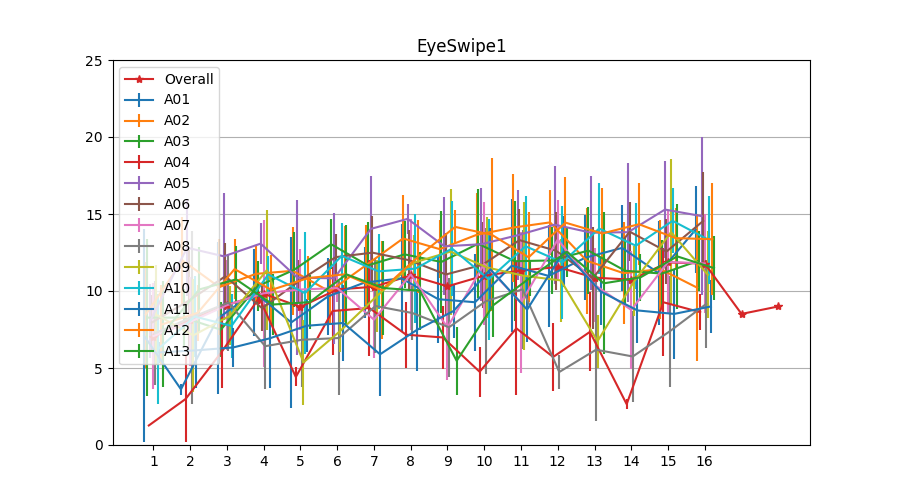

<IPython.core.display.Javascript object>


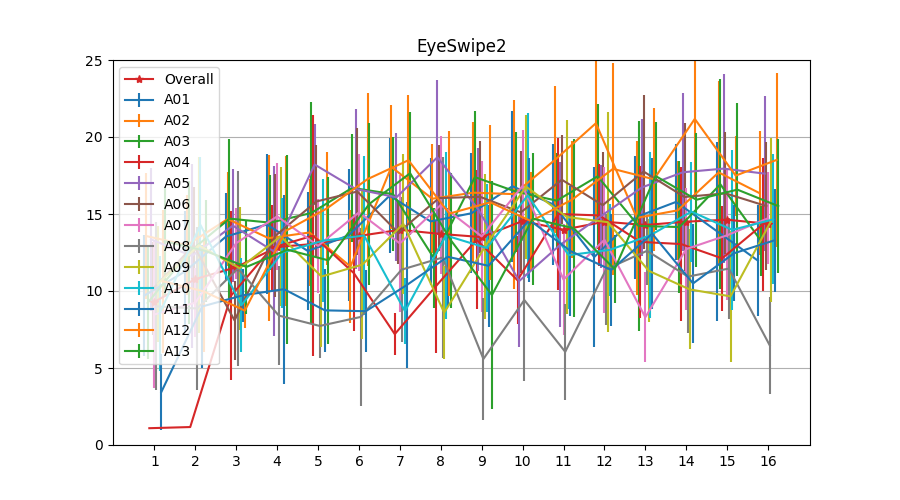

In [11]:

class DataPlotter(object):
    def __init__(self, key):
        self.key = key
        self.plots1 = None
        self.plots2 = None
        self.all_button = None
        self.checkboxes = None
        self.containers = None

    # Plot data
    def plot_data(self, mode, show_error=True, **kwargs):
        fig = plt.figure(figsize=(9, 5))
        all_means = []
        mode_values = typing_df[typing_df['mode_id'] == mode]
        plots = dict()
        for i, participant in enumerate(participants):
            participant_values = mode_values[mode_values['participant_id'] == participant].groupby('session_id')[self.key]
            all_means.append(participant_values.mean())
            yerrs = participant_values.std()
            if show_error:
                epsilon = 0.5 * (i / (len(participants) - 1) - 0.5)
            else:
                epsilon = 0
                yerrs = [0 for _ in yerrs]
            x = np.arange(1 + epsilon, len(all_means[-1]) + 1 + epsilon, 1)
            plots[participant] = plt.errorbar(x, all_means[-1], yerrs, label=participant)
        mean_values = mode_values.groupby(['participant_id', 'session_id'], as_index=False)[self.key].mean().groupby('session_id').mean()
        x = range(1, len(mean_values) + 1)
        plots['Overall'] = plt.plot(x, mean_values, '-*', label='Overall')
        plt.xticks(range(1, 1 + max([len(values) for values in all_means])))

        ax = plt.gca()
        ax.set_title(mode_names[mode])
        ax.legend(loc=2)
        if 'ylim' in kwargs:
            ax.set_ylim(kwargs['ylim'])
        ax.yaxis.grid(True)
        plt.show()
        return plots

    # Shows the plots for both modes
    def show(self, **kwargs):
        # Plot data
        self.plots1 = self.plot_data('eyeswipe1', **kwargs)
        self.plots2 = self.plot_data('eyeswipe2', **kwargs)

        # Helper button
        self.all_button = widgets.Button(description="Toggle Select All")
        display(self.all_button)
        self.all_button.on_click(self.toggle_all)
        
        # Create checkboxes
        self.checkboxes = [interactive(self.update_plot, **{p: True, 'participant': fixed(p)}) for p in participants + ['Overall']]
        
        # Display checkboxes
        self.containers = []
        for i in range(0, len(self.checkboxes), 4):
            cb_container = widgets.Box()
            cb_container.children = self.checkboxes[i:i+4]
            display(cb_container)
            self.containers.append(cb_container)

    # Change visibility of plot
    def set_visible(self, p, visible):
        p[0].set_visible(visible)
        if len(p) > 1:
            for p_i in p[1]:
                p_i.set_visible(visible)
        if len(p) > 2:
            for p_i in p[2]:
                p_i.set_visible(visible)

    # Create checkboxes to select participants
    def update_plot(self, **kwargs):
        participant = kwargs['participant']
        visible = kwargs[participant]
        for checkbox in self.checkboxes:
            self.set_visible(self.plots1[participant], visible)
            self.set_visible(self.plots2[participant], visible)

    # Callback for all_button
    def toggle_all(self, b):
        new_value = not any([c.children[0].value for c in self.checkboxes])
        for checkbox in self.checkboxes:
            checkbox.children[0].value = new_value


DataPlotter('wpm').show(ylim=(0, 25))


<IPython.core.display.Javascript object>


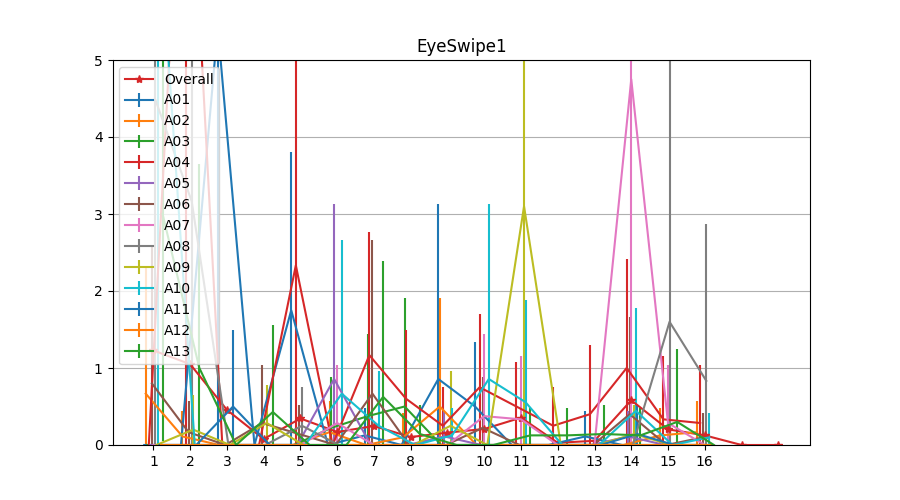

<IPython.core.display.Javascript object>


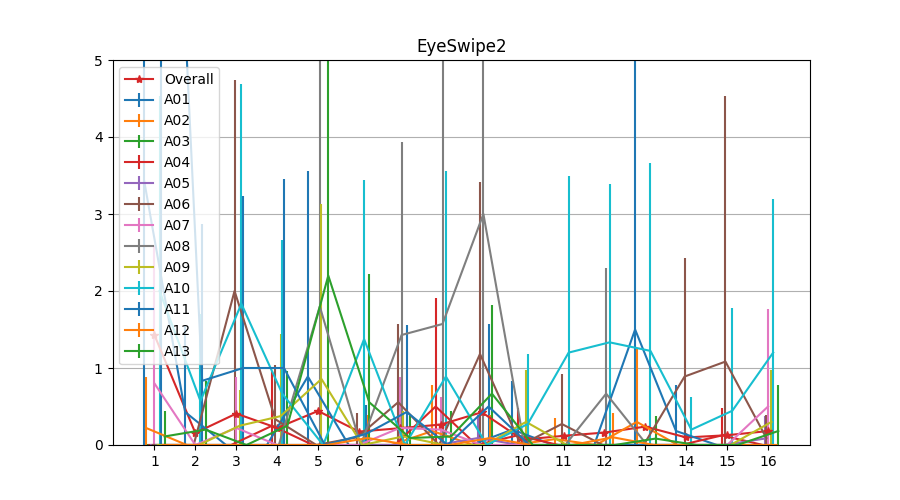

In [14]:
DataPlotter('msd').show(ylim=(0, 5))